# Real-time prediction
In my previous posts I showed different approaches on classifying images through neural networks. You may choose to create a neural network from scratch [Convolutional neural network for image classification from scratch](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/dropout/image%20classification/2017/04/23/convolutional-neural-network-from-scratch.html) or you prefer to use a pre-trained neural network like [Google's Inception](https://arxiv.org/abs/1409.4842) as demonstrated in [Image classification with pre-trained CNN InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/tensorflow/dropout/image%20classification/2017/05/04/cnn-image-classification-cifar-10-inceptionV3.html) and [Image classification with stacked InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/xgboost/ridgeregression/sklearn/tensorflow/image%20classification/imagenet/2017/05/11/cnn-image-classification-cifar-10-stacked-inceptionV3.html). Anyway, shortly after blogging about using stacked models for image classification I received a comment from a friend working in the Big Data department of a commercial bank in the Netherlands. What he wanted to see is how the machine learning scripts could be integrated into their existing Big Data infrastructure that is largely based on real-time communication with [Apache Kafka](https://kafka.apache.org/).A few days later, a friend working for the hedge fund industry in London called. He is currently prototyping different trading models with [R Statistics](https://www.r-project.org/). He was interested in how one could combine the predictive power of tens, possibly hundreds of R scripts und use these for real-time trading. Well, coming from the software engineering part of the computer science word and having worked in the Java Enterprise domain for several years now, I decided to write a series of posts and demonstrate how one could integrate a model stack and use it in real-time. 

In this first post of the series, I will create a model stack consisting of [Google's InceptionV3](https://arxiv.org/abs/1512.00567) and a second classification model. Hence, what I will do here is very similar to my previous post [Image classification with stacked InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/xgboost/ridgeregression/sklearn/tensorflow/image%20classification/imagenet/2017/05/11/cnn-image-classification-cifar-10-stacked-inceptionV3.html). In part 2 of this series I will show how one can use the model stack to create a predictive kafka service. In part 3, I will show you how you can quickly start kafka and build a web application that utilizes the predictive service in real-time. 

The smart pipeline that I am going to build here can be used in finance and many other industries. However, comprehensive financial data is not very visually appealing and not that fun. So I will be building an online real-time Cat vs Dog image classifier. In this first post we will train the models and build the classifier.

# Preparing the cat & dog dataset

I am going to use the training set provided in the last [Cat vs Dog Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition). It consists of 25,000 images of cats and dogs. Downloading the dataset from script is a bit problematic, as you have to agree with the competition's rules to be able to download. Assuming, you manually downloaded the training set and unzipped it in a directory called image_data you start by reading all image paths like this:

In [1]:
from random import shuffle
import glob
import numpy as np

# read addresses and labels from the 'train' folder
image_paths = glob.glob('image_data/*.jpg')

# Create labels 0 = Cat and 1 = Dog
labels = [0 if 'cat' in image_path else 1 for image_path in image_paths]  

training_set = list(zip(image_paths, labels))

shuffle(training_set)

Next, the images have to be converted to Tensorflow Records (tfrecords). If you take a look at the images, you will notice that they have fairly arbitrary sizes and aspect ratios. While converting the images, you will definitely want to resize these to the input size required by the neural network, that is 299 x 299 pixels. This way you will save on both disk space (most of the images are larger than 299 x 299) and compute time while training as no resizing will be needed. While converting you may also want to print out the first few images and make sure they look ok.

  0%|          | 0/25000 [00:00<?, ?it/s]

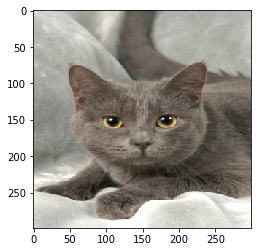

  0%|          | 1/25000 [00:00<2:08:11,  3.25it/s]

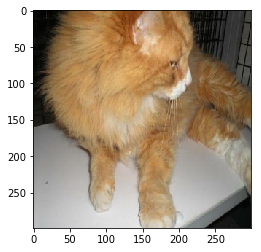

  0%|          | 2/25000 [00:00<2:13:32,  3.12it/s]

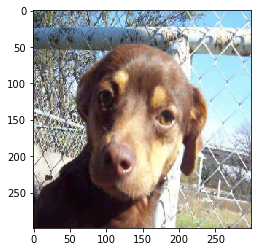

  0%|          | 3/25000 [00:00<2:11:24,  3.17it/s]

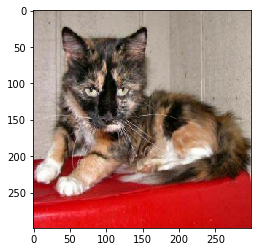

  0%|          | 4/25000 [00:01<2:12:23,  3.15it/s]

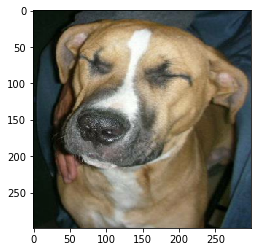

  0%|          | 5/25000 [00:01<2:12:48,  3.14it/s]

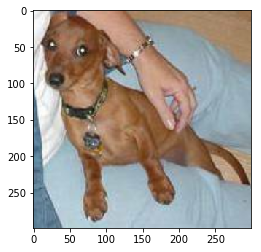

  0%|          | 6/25000 [00:01<2:14:21,  3.10it/s]

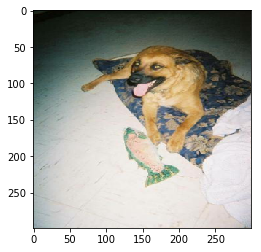

  0%|          | 7/25000 [00:02<2:15:07,  3.08it/s]

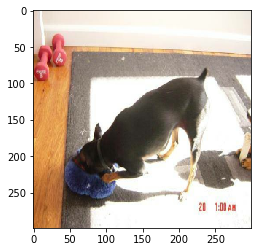

  0%|          | 8/25000 [00:02<2:13:21,  3.12it/s]

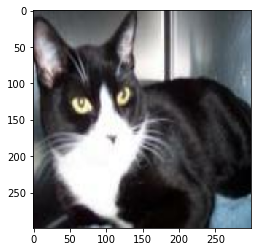

  0%|          | 9/25000 [00:02<2:17:16,  3.03it/s]

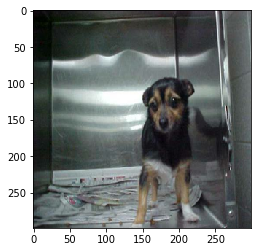

100%|██████████| 25000/25000 [21:13<00:00, 19.63it/s]  


In [2]:
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
               
import os

IMAGE_SIZE = 299
TRAIN_SET_FILE = os.path.join('tfrecord', 'train')
TRAINING_SET_SIZE = len(training_set)

def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def to_example(png_image_data, label):
     return tf.train.Example(features=tf.train.Features(feature={
          'image/encoded': bytes_feature(png_image_data),
          'image/format': bytes_feature('png'.encode('utf-8')),
          'image/height': int64_feature(IMAGE_SIZE),
          'image/width': int64_feature(IMAGE_SIZE),
          'image/class/label': int64_feature(label)
    }))

def log_image(png_image_string):
    with open('sample.png', 'wb') as f:
        f.write(png_image_string)
    img=mpimg.imread('sample.png')
    imgplot = plt.imshow(img)
    plt.show()
    os.remove('sample.png')

def create_tfrecord(dataset, tfrecrod_file_name):
    
    with tf.python_io.TFRecordWriter(os.path.join(tfrecrod_file_name)) as tfrecord_writer:
        
        tf.reset_default_graph()
        
        image_size = tf.constant([IMAGE_SIZE,IMAGE_SIZE], dtype=tf.int32)
        
        image_path_placeholder = tf.placeholder(dtype=tf.string)
        file_contents = tf.read_file(image_path_placeholder)
        image_data = tf.image.decode_jpeg(file_contents, channels=3)
        resized_image = tf.image.resize_images(image_data, image_size)
        png_image = tf.image.encode_png(tf.cast(resized_image, tf.uint8))

        with tf.Session() as sess:

            # Initializing the variables
            sess.run(tf.global_variables_initializer())

            for i in tqdm(range(TRAINING_SET_SIZE)):                
                image_path, label = dataset[i]
                png_image_string = sess.run(png_image, feed_dict={image_path_placeholder: image_path})
                example = to_example(png_image_string, label)
                
                tfrecord_writer.write(example.SerializeToString())
                # Show first 10 images
                if i < 10:
                    log_image(png_image_string)



if not os.path.isdir('tfrecord'):
    os.mkdir('tfrecord')
    create_tfrecord(training_set, TRAIN_SET_FILE)

# Preparing InceptionV3
In my previous post I was able to reach fairly good results when classifying images from the Cifar-10 dataset by using the InceptionV3 convolutional neural network (CNN). Here are few lines of code to directly download the InceptionV3 weights of the neural network.

In [4]:
# DOWNLOAD DATASET 
from urllib.request import urlretrieve
import os
from tqdm import tqdm
import tarfile

inceptionv3_archive = os.path.join('model', 'inception_v3_2016_08_28.tar.gz')

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not os.path.isdir('model'):
    # create directory to store model
    os.mkdir('model')
    # download the model
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='InceptionV3') as pbar:
        urlretrieve(
            # I hope this url stays there
            'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz',
            inceptionv3_archive,
            pbar.hook)

    with tarfile.open(inceptionv3_archive) as tar:
        tar.extractall('model')
        tar.close()

InceptionV3: 101MB [00:55, 1.83MB/s]                              


# Using InceptionV3 as first level classifier
Here are a couple of functions for preparing the dataset and loading a batch. 

In [3]:
import inception_preprocessing

def load_batch(dataset, batch_size, height, width, is_training=False):
    data_provider = slim.dataset_data_provider.DatasetDataProvider(
        dataset, common_queue_capacity=32, common_queue_min=8)
    image_raw, label = data_provider.get(['image', 'label'])
    
    # Preprocess image for usage by Inception.
    image = inception_preprocessing.preprocess_image(
        image_raw, height, width, is_training=is_training)
    
    # Preprocess the image for display purposes.
    image_raw = tf.expand_dims(image_raw, 0)
    image_raw = tf.image.resize_images(image_raw, [height, width])
    image_raw = tf.squeeze(image_raw)

    # Batch it up.
    images, images_raw, labels = tf.train.batch(
          [image, image_raw, label],
          batch_size=batch_size,
          num_threads=1,
          capacity=2 * batch_size)
    
    return images, images_raw, labels

def get_dataset(dataset_file_name, train_sample_size):

    keys_to_features = {
          'image/encoded': tf.FixedLenFeature((), tf.string, default_value=''),
          'image/format': tf.FixedLenFeature((), tf.string, default_value='png'),
          'image/class/label': tf.FixedLenFeature(
              [], tf.int64, default_value=tf.zeros([], dtype=tf.int64)),
    }

    items_to_handlers = {
          'image': slim.tfexample_decoder.Image(shape=[IMAGE_SIZE, IMAGE_SIZE, 3]),
          'label': slim.tfexample_decoder.Tensor('image/class/label'),
    }
    
    ITEMS_TO_DESCRIPTIONS = {
        'image': 'A [299 x 299 x 3] color image.',
        'label': 'A single integer that is 0 or 1 for cat and dog',
    }

    decoder = slim.tfexample_decoder.TFExampleDecoder(keys_to_features, items_to_handlers)

    return slim.dataset.Dataset(
          data_sources=dataset_file_name,
          reader=tf.TFRecordReader,
          decoder=decoder,
          num_samples=train_sample_size,
          items_to_descriptions=ITEMS_TO_DESCRIPTIONS,
          num_classes=2, # cat and dog
          labels_to_names={0:'cat', 1:'dog'})

Same as in [Image classification with stacked InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/xgboost/ridgeregression/sklearn/tensorflow/image%20classification/imagenet/2017/05/11/cnn-image-classification-cifar-10-stacked-inceptionV3.html) we are going to use InceptionV3 as a first level classifier in a stack of classifiers consisting of two levels. In the code below the InceptionV3 model is loaded and without any training whatsoever it is used to make a prediction for all images in the training set. Note that the unmodified InceptionV3 model has an output that is a vector of length 1001. For each image this output vector is saved to be later used as un input for the second level classifier.

In [4]:
from inception_v3 import inception_v3
from inception_v3 import inception_v3_arg_scope
from tqdm import tqdm

BATCH_SIZE = 50
NUMBER_OF_STEPS = int(TRAINING_SET_SIZE / BATCH_SIZE)
INCEPTION_OUTPUT_SIZE = 1001

INCEPTION_MODEL_FILE = os.path.join('model','inception_v3.ckpt')

slim = tf.contrib.slim

meta_data_train_X = []
meta_data_train_Y = []

tf.reset_default_graph()

tf.logging.set_verbosity(tf.logging.ERROR)
    
train_dataset = get_dataset(TRAIN_SET_FILE, TRAINING_SET_SIZE)
images, images_raw, labels = load_batch(
      train_dataset, BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE)
    
# Create the model, use the default arg scope to configure the batch norm parameters.
with slim.arg_scope(inception_v3_arg_scope()):
    logits, _ = inception_v3(images, num_classes=INCEPTION_OUTPUT_SIZE, is_training=False)

probabilities = tf.nn.softmax(logits)
    
init_fn = slim.assign_from_checkpoint_fn(
    INCEPTION_MODEL_FILE, slim.get_model_variables())
    
with tf.Session() as sess:
    with slim.queues.QueueRunners(sess):
        sess.run(tf.initialize_local_variables())
        init_fn(sess)
        for i in tqdm(range(NUMBER_OF_STEPS)):
            np_probabilities, np_images_raw, np_labels = sess.run([probabilities, images_raw, labels])
            meta_data_train_X += np_probabilities.tolist()
            meta_data_train_Y += np_labels.tolist()

100%|██████████| 500/500 [1:42:42<00:00, 13.21s/it]


It does not hurt to save the outputs to the disk in case the python notebook kernel crashes…

In [ ]:
import pickle

assert len(meta_data_train_X) == TRAINING_SET_SIZE
assert len(meta_data_train_Y) == TRAINING_SET_SIZE

with open('meta_data_train_inceptionV3.p', 'wb') as handle:
    pickle.dump((meta_data_train_X, meta_data_train_Y), handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('meta_data_train_inceptionV3.p', 'rb') as handle:
    meta_data_train_X, meta_data_train_Y = pickle.load(handle)

# Selecting second level classifier
Once the training data set goes through the InceptionV3 network, you are all set to use the output vectors that have been produced as a training set for a second level classifier, Hence, the next task is to choose the second level classifier. As an input it receives the output vectors created by the unmodified InceptionV3 neural network. Its output, however, is the actual label - 0 for a cat and 1 for a dog. As in the [Image classification with stacked InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/xgboost/ridgeregression/sklearn/tensorflow/image%20classification/imagenet/2017/05/11/cnn-image-classification-cifar-10-stacked-inceptionV3.html) I will train three different second level classifiers in order to compare their performance. I will start with the most simple classifier possible, linear regression with L2 regularization, that is also known as ridge regression classifier. It is not a bad idea to use a 5-fold cross validation in order to evaluate the classifier’s accuracy without actually using the test set.

In [9]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score

ridge_classifier = RidgeClassifier(alpha=1e-5)
scores = cross_val_score(ridge_classifier, meta_data_train_X, meta_data_train_Y, cv=5)

print('Accuracy ridge classifier', np.mean(scores))

Accuracy ridge classifier 0.985839999798


Even with the most simple second level classifier possible i.e. linear regression we get 98.58% accuracy. This is not surprising at all. There are a lot of cats and dogs in the [Imagenet](http://www.image-net.org/) dataset that has been used by Google when training the Inception models. Let's check if accuracy can be improved with a fully connected network. The dataset is split into a training and test set that contains 23,000 and 2,000 images respectively. The test set is needed to measure performance. After every 30 steps we print out the performance.

In [ ]:
train_X, train_Y = np.array(meta_data_train_X[:23000], dtype=np.float32), meta_data_train_Y[:23000]
validation_X, validation_Y = np.array(meta_data_train_X[23000:], dtype=np.float32), meta_data_train_Y[23000:]

tf.logging.set_verbosity(tf.logging.ERROR)
tf.reset_default_graph()
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(train_X)
dnnClassifier = tf.contrib.learn.DNNClassifier(hidden_units=[2048, 512, 64],
                                            feature_columns=feature_columns,  
                                            n_classes=30,
                                            model_dir='second_leveld_dnn',
                                            dropout=0.4,
                                            optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

for i in tqdm(range(10)):
    dnnClassifier.fit(x=train_X, y=train_Y, steps=30)
    accuracy_score = dnnClassifier.evaluate(x=validation_X, y=validation_Y, steps=1)["accuracy"]
    print('Accuracy DNNClassifier',accuracy_score)

  0%|          | 0/10 [00:00<?, ?it/s]/home/freeman/anaconda3/envs/machinelearning/lib/python3.5/site-packages/tensorflow/python/util/deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b
 10%|█         | 1/10 [03:42<33:26, 222.93s/it]

Accuracy DNNClassifier 0.9905


 20%|██        | 2/10 [07:22<29:34, 221.87s/it]

Accuracy DNNClassifier 0.9905


 30%|███       | 3/10 [11:05<25:56, 222.34s/it]

Accuracy DNNClassifier 0.991


 40%|████      | 4/10 [14:59<22:34, 225.67s/it]

Accuracy DNNClassifier 0.992


 50%|█████     | 5/10 [18:39<18:40, 224.16s/it]

Accuracy DNNClassifier 0.992


 60%|██████    | 6/10 [22:24<14:57, 224.30s/it]

Accuracy DNNClassifier 0.991


 70%|███████   | 7/10 [26:16<11:19, 226.62s/it]

Accuracy DNNClassifier 0.9915


 80%|████████  | 8/10 [30:00<07:31, 225.69s/it]

Accuracy DNNClassifier 0.991


 90%|█████████ | 9/10 [33:56<03:48, 228.91s/it]

Accuracy DNNClassifier 0.991


100%|██████████| 10/10 [37:30<00:00, 224.40s/it]

Accuracy DNNClassifier 0.991


Indeed, the accuracy gets even better and reaches 99.1%. Nevertheless in [Image classification with stacked InceptionV3](http://machinememos.com/python/artificial%20intelligence/machine%20learning/cifar10/neural%20networks/convolutional%20neural%20network/googlelenet/inception/xgboost/ridgeregression/sklearn/tensorflow/image%20classification/imagenet/2017/05/11/cnn-image-classification-cifar-10-stacked-inceptionV3.html) the best performance was reached by the boosted trees classifier [xgboost](http://xgboost.readthedocs.io/en/latest/python/python_intro.html). Let's try it in a 5-fold cross validaiton.

In [5]:
import xgboost
from sklearn.model_selection import cross_val_score
import numpy as np

xgb_classifier = xgboost.XGBClassifier(learning_rate=0.1,
 n_estimators=100,
 max_depth=4)

X = np.array(meta_data_train_X)

scores = cross_val_score(xgb_classifier,  np.array(meta_data_train_X), np.array(meta_data_train_Y), cv=5, verbose=True)
print('Accuracy xgboost', np.mean(scores))

Accuracy xgboost 0.992199967875


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished


And once again xgboost did not disappoint and reached the best accuracy of 99,22%. For the next part of this series I will be using xgboost as a second level classifier that makes the final decision between a cat and a dog. Therefore, xgboost is trained once again by using all the data and saved to the disk.

In [6]:
# Prepare classifier
xgb_classifier = xgboost.XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4).fit(np.array(meta_data_train_X), np.array(meta_data_train_Y))

In [7]:
with open('xgboost_model.p', 'wb') as handle:
    pickle.dump(xgb_classifier, handle, protocol=pickle.HIGHEST_PROTOCOL)

In the second part of this series I will use the small stack consisting of InceptionV3 and xgboost to create a micro service. The micro service will be subscribed to the Apache Kafka event bus and will be used for real-time image classification. As always you can checkout out the whole repo here: [catdog-realtime-classification-kafka-service](https://github.com/n-kostadinov/catdog-realtime-classification-kafka-service)